# Model Tuning
---

### Import Packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

import params as p
import functions as f

from xgboost import XGBRegressor


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import optuna
from optuna.integration import XGBoostPruningCallback

/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Settings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import Data

In [3]:
# Load train, test and validation datasets
train, test, val = f.load_split_datasets(part='03')

In [4]:
# Split datasets into X and y components
X_train, y_train = f.split_data_X_y(train)
X_test, y_test = f.split_data_X_y(test)
X_val, y_val = f.split_data_X_y(val)

In [5]:
# Define train/test/validation dictionaries to make fitting and evaluation arguments cleaner
train_data = {'X' : X_train, 'y' : y_train}
test_data = {'X' : X_test, 'y' : y_test}
val_data = {'X' : X_val, 'y' : y_val}

### Create Initial Models

In [6]:
print('lr model...', end = ' ')
lr = LinearRegression().fit(**train_data)
print('trained')

print('xgb model...', end = ' ')
xgb = XGBRegressor(random_state = p.RANDOM_STATE).fit(**train_data)
print('trained')

print('rf model...', end = ' ')
rf = RandomForestRegressor(random_state=p.RANDOM_STATE).fit(**train_data)
print('trained')

print('nb model...', end = ' ')
nb = GaussianNB().fit(**train_data)
print('trained')

lr model... trained
xgb model... trained
rf model... trained
nb model... trained


### Evaluate Initial Models on Validation Data

In [7]:
models = [lr, xgb, rf, nb]

rmse = {
    'r2_train' : [f.evaluate_model(model, metric = 'r2', **train_data) for model in models],
    'r2_test' : [f.evaluate_model(model, metric = 'r2', **test_data) for model in models]
    }
initial_results = pd.DataFrame(rmse, index = ['Linear Regresssion', 'XGBoost', 'RandomForest', 'Naive Bayes'])
initial_results

,r2_train,r2_test
Linear Regresssion,0.567670,0.551524
XGBoost,0.986061,0.910505
RandomForest,0.983250,0.883622
Naive Bayes,0.626994,0.317068


1. The Linear Regression model does show a reasonable performance and, since we cannot tune it, will provide a good baseline to compare our initial results against.

1. We can see that the XGBoost model does seem to have the best performance currently with R2 scores of 0.986061 and 0.910505 from train and test respectively. However, the RandomForest model does show similar R2, albeit slightly lower. Since these are the two models that are more open to extensive tuning, initial results show that the most appropriate model will be one of these. Comparing these models to our baseline, we can see that we have already got more value out changing the model before tuning.

1. Our Naive Bayes Model is already showing signs of over fitting with the train R2 score an improvement on our baseline score. It will be worth tuning this model to see if we can get anything more out of it, but initial results point to one of the tree-based models.

### Model Tuning - Optuna

We will be using the optuna framework to train our models due to the improved performance on sklearn's `RandomizedSearchCV` and the nice structure optuna brings.

1. We start with the XGBoost tuning, breaking it down into three sections: Tree-based parameters, Regularization Parameters and Learning Rate. We will use a separate optuna study for each section to effectively tune the model and avoid over fitting. Tree-based parameters include `max_depth`, `min_child_weight`, `n_estimators`, `subsample`, `gamma` and `colsample_by_tree`; Regularization parameters include `alpha` and `lambda` to focus on over fitting control; and the final section just looks at finding the optimal `learning_rate` based on the other optimal parameters.

1. Since all the RandomForest parameters fall into the same category, we can use a single optuna study to tune this model. The parameters that we will be tuning are the following: `max_depth`, `max_features`, `n_estimators`, `bootstrap`, `min_samples_leaf` and `min_samples_split`.

1. The final model to tune is the Naive Bayes model which only requires tuning of `var_smoothing` which helps control over fitting.

### XGB Tuning

#### Tune Tree-Specific Parameters

In [8]:
xgb_base_params = {
    'learning_rate' : 0.3,
    'verbosity' : 0,
    'n_jobs' : -1,
    'random_state' : p.RANDOM_STATE,
    }

def xgb_objective1(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, base_params = xgb_base_params):

    obj_params = {
        'max_depth' : trial.suggest_int('max_depth', 2, 5),
        'min_child_weight' : trial.suggest_int('min_child_weight', 5, 10),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'subsample' : trial.suggest_float('subsample', 0.1, 1),
        'gamma': trial.suggest_loguniform('gamma', 1e-2, 10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),

        **base_params
        }

    pruning_callback = XGBoostPruningCallback(trial, observation_key = 'validation_1-rmse')

    xgb_obj = XGBRegressor(**obj_params)
    xgb_obj.fit(
        X_train,
        y_train,
        eval_metric = 'rmse',
        eval_set = [(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = obj_params['n_estimators'] * 0.1,
        verbose = 0,
        callbacks = [pruning_callback]
        )

    y_pred = xgb_obj.predict(X_test)

    r2 = r2_score(y_pred=y_pred, y_true=y_test)
    
    return r2

xgb_study1 = optuna.create_study(direction = 'maximize')
xgb_study1.optimize(xgb_objective1, n_trials = 200, n_jobs = -1)

[I 2022-03-27 13:43:42,203] A new study created in memory with name: no-name-54006c54-95e4-4551-91cc-7fdfe355bcde
[I 2022-03-27 13:43:46,871] Trial 6 finished with value: 0.8963777945588463 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 286, 'subsample': 0.7848572688742363, 'gamma': 0.02630213863121009, 'colsample_bytree': 0.9481349328226745}. Best is trial 6 with value: 0.8963777945588463.
[I 2022-03-27 13:43:49,065] Trial 1 finished with value: 0.8793143327423179 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 770, 'subsample': 0.5368125783015241, 'gamma': 6.730819264838747, 'colsample_bytree': 0.5813529687407211}. Best is trial 6 with value: 0.8963777945588463.
[I 2022-03-27 13:43:50,668] Trial 2 finished with value: 0.8769346443788251 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 649, 'subsample': 0.7728536805958359, 'gamma': 0.024442354161341804, 'colsample_bytree': 0.355787034345446}. Best is trial 6 with 

#### Tune Regularization Parameters

In [9]:
def xgb_objective2(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, base_params = {**xgb_base_params, **xgb_study1.best_params}):

    obj_params = {
        'lambda': trial.suggest_loguniform('lambda', 1e-2, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-2, 10.0),

        **base_params
        }

    pruning_callback = XGBoostPruningCallback(trial, observation_key = 'validation_1-rmse')

    xgb_obj = XGBRegressor(**obj_params)
    xgb_obj.fit(
        X_train,
        y_train,
        eval_metric = 'rmse',
        eval_set = [(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = obj_params['n_estimators'] * 0.1,
        verbose = 0,
        callbacks = [pruning_callback]
        )

    y_pred = xgb_obj.predict(X_test)

    r2 = r2_score(y_pred=y_pred, y_true=y_test)
    
    return r2

xgb_study2 = optuna.create_study(direction = 'maximize')
xgb_study2.optimize(xgb_objective2, n_trials = 200, n_jobs = -1)

[I 2022-03-27 13:45:40,672] A new study created in memory with name: no-name-581fdb45-8f5a-48b4-801e-d0580c8faf33
[I 2022-03-27 13:45:44,223] Trial 5 finished with value: 0.8909848429044313 and parameters: {'lambda': 0.03446215253234869, 'alpha': 0.013966321084662692}. Best is trial 5 with value: 0.8909848429044313.
[I 2022-03-27 13:45:44,676] Trial 3 finished with value: 0.8927017325255292 and parameters: {'lambda': 0.22564625423405046, 'alpha': 0.01400364204133667}. Best is trial 3 with value: 0.8927017325255292.
[I 2022-03-27 13:45:44,908] Trial 4 finished with value: 0.8957191932200208 and parameters: {'lambda': 3.559805903688366, 'alpha': 0.024699347385683818}. Best is trial 4 with value: 0.8957191932200208.
[I 2022-03-27 13:45:44,989] Trial 6 finished with value: 0.893504348479239 and parameters: {'lambda': 3.0674414754487946, 'alpha': 0.8128818906246428}. Best is trial 4 with value: 0.8957191932200208.
[I 2022-03-27 13:45:45,161] Trial 2 finished with value: 0.8914375615722335 a

#### Tune learning_rate

Since there are such a small range of values for the `learning_rate` we will revert to a simple loop to choose the best rate.

In [14]:
xgb_base_params_lr = {
    'verbosity' : 0,
    'n_jobs' : -1,
    'random_state' : p.RANDOM_STATE,

    **xgb_study1.best_params,
    **xgb_study2.best_params
    }

lr_params = [0.3, 0.1, 0.05, 0.03]

lr_out = {'train' : [], 'test' :[]}

for lr in lr_params:

    lr_xgb = XGBRegressor(**xgb_base_params_lr, learning_rate = lr)
    lr_xgb.fit(
        X_train,
        y_train,
        eval_metric = 'rmse',
        eval_set = [(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = xgb_base_params_lr['n_estimators'] * 0.1,
        verbose = 0,
        )

    y_pred_train = lr_xgb.predict(X_train)
    y_pred_test = lr_xgb.predict(X_test)


    lr_out['train'].append(r2_score(y_pred=y_pred_train, y_true=y_train))
    lr_out['test'].append(r2_score(y_pred=y_pred_test, y_true=y_test))

results = pd.DataFrame(lr_out, index = lr_params)
results

,train,test
0.30,0.979083,0.902061
0.10,0.960303,0.907406
0.05,0.937504,0.899382
0.03,0.920609,0.889195


We need to make a decision between bias and variance here based on the above results. If we were prioritizing minimizing variance, we would choose a `learning_rate` of 0.3 since here the model is over fit. Whereas, if our focus was on minimizing bias, we would choose a `learning_rate` of 0.03. Since we have both R2 scores in the 0.9s in both cases, we will opt for a learning rate of 0.03.

In [15]:
learning_rate = 0.03

In [12]:
xgb_tuned_params = {**xgb_study1.best_params, **xgb_study2.best_params, **xgb_base_params_lr, 'learning_rate' : learning_rate}
xgb_tuned_params

NameError: name 'xgb_study3' is not defined

In [ ]:
xgb_tuned = XGBRegressor(**xgb_tuned_params)
xgb_tuned.fit(
    **train_data,
    eval_metric = 'rmse',
    eval_set = [(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds = xgb_tuned_params['n_estimators'] * 0.1,
    verbose = 0
    )

XGBRegressor(alpha=2.4545977534080894, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7871034584624566, enable_categorical=False,
             gamma=4.501784396263185, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=7.948545364699994,
             learning_rate=0.3, max_delta_step=0, max_depth=4,
             min_child_weight=8, missing=nan, monotone_constraints='()',
             n_estimators=425, n_jobs=-1, num_parallel_tree=1, predictor='auto',
             random_state=73, reg_alpha=2.45459771, reg_lambda=7.94854546,
             scale_pos_weight=1, subsample=0.7910966911216083,
             tree_method='exact', validate_parameters=1, verbosity=0)

In [ ]:
print('Train R2:', f.evaluate_model(xgb_tuned, metric = 'r2', **train_data))
print('Test R2:', f.evaluate_model(xgb_tuned, metric = 'r2', **test_data))

Train R2: 0.976431
Test R2: 0.901145


# !!! need to look at this !!!

R2 scores of 0.907103 and 0.877968 on our train and test data respectively is a good finish to our tuning. We can see that we have slight reduction to the scores from our initial models, but significantly reduced the over fitting that was going on. We will look at the score on the validation data in final model comparisons to see how this model compares to the tuned RandomForest and Naive Bayes models.

### RandomForest Model Tuning

As mentioned, since the RandomForest hyperparameters are tree-based, we can tune them all with a single study. The parameters we will be tuning are the following: `max_depth`, `max_features`, `n_estimators`, `bootstrap`, `min_samples_leaf` and `min_samples_split`.

In [ ]:
rf_base_params = {
    'verbose' : 0,
    'random_state' : p.RANDOM_STATE,
    }

def rf_objective(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, base_params = rf_base_params):

    obj_params = {
        'max_depth' : trial.suggest_int('max_depth', 2, 8),
        'max_features' : trial.suggest_categorical('max_features', ['auto', 'sqrt']),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'bootstrap' : trial.suggest_categorical('bootstrap', [True, False]),
        'min_samples_leaf' : trial.suggest_float('min_samples_leaf', 0, 0.5),
        'min_samples_split' : trial.suggest_float('min_samples_split', 0, 0.5),

        **base_params
    }

    rf_obj = RandomForestRegressor(**obj_params)
    rf_obj.fit(X_train, y_train)

    y_pred = rf_obj.predict(X_test)

    r2 = r2_score(y_pred=y_pred, y_true=y_test)
    
    return r2

rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials = 200, n_jobs = -1)

[I 2022-03-27 13:41:59,914] A new study created in memory with name: no-name-0b74af97-062d-4470-908f-8081eeccd084
[I 2022-03-27 13:42:02,080] Trial 7 finished with value: 0.24764651114144343 and parameters: {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 352, 'bootstrap': False, 'min_samples_leaf': 0.3543164377194608, 'min_samples_split': 0.42908723530942466}. Best is trial 7 with value: 0.24764651114144343.
[I 2022-03-27 13:42:02,623] Trial 3 finished with value: 0.15281364998964775 and parameters: {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 765, 'bootstrap': False, 'min_samples_leaf': 0.4676636870419025, 'min_samples_split': 0.456567470635204}. Best is trial 7 with value: 0.24764651114144343.
[I 2022-03-27 13:42:02,887] Trial 4 finished with value: 0.4396982133649806 and parameters: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 304, 'bootstrap': False, 'min_samples_leaf': 0.037526142709928545, 'min_samples_split': 0.25814798080446716}. Best is trial 4

KeyboardInterrupt: 

In [ ]:
rf_tuned_params = {**rf_study.best_params, **rf_base_params}
rf_tuned_params

{'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 325,
 'bootstrap': True,
 'min_samples_leaf': 0.0006016852623903109,
 'min_samples_split': 0.008483953365621627,
 'verbose': 0,
 'random_state': 73}

In [ ]:
rf_tuned = RandomForestRegressor(**rf_tuned_params).fit(**train_data)

In [ ]:
print('Train R2:', f.evaluate_model(rf_tuned, metric = 'r2', **train_data))
print('Test R2:', f.evaluate_model(rf_tuned, metric = 'r2', **test_data))

Train R2: 0.790954
Test R2: 0.755421


R2 scores of ________ and ______ on our train and test data respectively ________.

### Naive Bayes Model Tuning

We use another optuna study to find the best value of `var_smoothing` for the performance of our Naive Bayes model.

In [ ]:
def nb_objective(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):

    obj_params = {
        'var_smoothing' : trial.suggest_loguniform('var_smoothing', 1e-5, 1),
    }

    nb_obj = GaussianNB(**obj_params)
    nb_obj.fit(X_train, y_train)

    y_pred = nb_obj.predict(X_test)

    r2 = r2_score(y_pred=y_pred, y_true=y_test)
    
    return r2

nb_study = optuna.create_study(direction='maximize')
nb_study.optimize(nb_objective, n_trials = 200, n_jobs = -1)

[I 2022-03-27 12:39:41,333] A new study created in memory with name: no-name-ced4950f-4b3d-45b9-833e-e795b5b8ed8c
[I 2022-03-27 12:39:44,078] Trial 2 finished with value: 717.1044376910611 and parameters: {'var_smoothing': 0.023383111794964807}. Best is trial 2 with value: 717.1044376910611.
[I 2022-03-27 12:39:44,084] Trial 3 finished with value: 729.9460201327851 and parameters: {'var_smoothing': 0.017436629617785752}. Best is trial 2 with value: 717.1044376910611.
[I 2022-03-27 12:39:44,121] Trial 7 finished with value: 796.1518491242141 and parameters: {'var_smoothing': 0.0002308028421692097}. Best is trial 2 with value: 717.1044376910611.
[I 2022-03-27 12:39:44,125] Trial 4 finished with value: 868.8138336345669 and parameters: {'var_smoothing': 0.1373318844043574}. Best is trial 2 with value: 717.1044376910611.
[I 2022-03-27 12:39:44,132] Trial 6 finished with value: 837.7671425922006 and parameters: {'var_smoothing': 0.0012791235135597872}. Best is trial 2 with value: 717.104437

In [ ]:
nb_tuned_params = nb_study.best_params.copy()
nb_tuned_params

{'var_smoothing': 1.0057743330451557e-05}

In [ ]:
nb_tuned = GaussianNB(**nb_tuned_params).fit(**train_data)

In [ ]:
print('Train R2:', f.evaluate_model(nb_tuned, metric = 'r2', **train_data))
print('Test R2:', f.evaluate_model(nb_tuned, metric = 'r2', **test_data))

Train R2: 0.790954
Test R2: 0.755421


### Evaluate Final, Tuned Models on validation data

In [ ]:
tuned_models = [lr, xgb_tuned, rf_tuned, nb_tuned]

tuned_rmse = {
    'r2_train' : [f.evaluate_model(model, metric = 'r2', **train_data) for model in tuned_models],
    'r2_test' : [f.evaluate_model(model, metric = 'r2', **test_data) for model in tuned_models],
    'r2_val' : [f.evaluate_model(model, metric = 'r2', **val_data) for model in tuned_models]
    }
    
pd_rmse = pd.DataFrame(tuned_rmse, index = ['Linear Regression', 'Tuned XGBoost', 'Tuned RandomForest', 'Tuned Naive Bayes'])
pd_rmse

,r2_train,r2_test,r2_val
XGBoost,0.985,0.907,0.893
RandomForest,0.775,0.739,0.758
Naive Bayes,0.519,0.390,0.372


Looks like _____ model is the best

#### Make Plot to show Residuals for each model

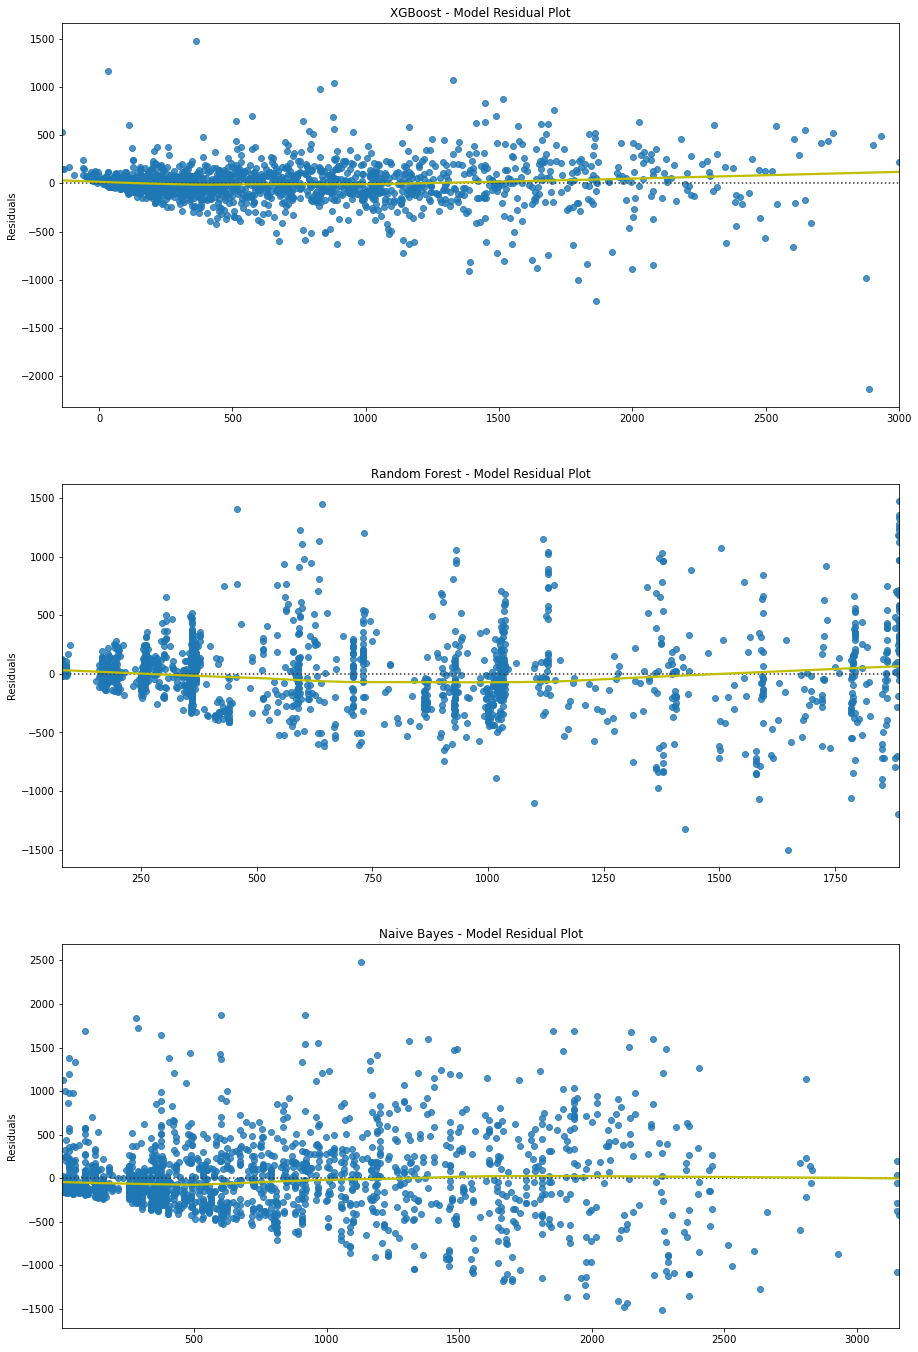

In [ ]:
def make_residual_plot():

    fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(15, 24))

    for idx, model_info in enumerate([('XGBoost', xgb_tuned), ('Random Forest', rf_tuned), ('Naive Bayes', nb_tuned)]):

        model_name = model_info[0]
        model = model_info[1]

        sns.residplot(
            ax = ax[idx],
            x = model.predict(X_val),
            y = y_val,
            lowess = True,
            line_kws = {'color' : 'y'}
        ).set(title = f'{model_name} - Model Residual Plot', ylabel = 'Residuals')

    plt.show()

make_residual_plot()